# DB Comparison
This notebook compares pScores between badapple_classic and the "badappleUpdated" database, which contains the same assay records as badapple_classic but has updated information (as of Nov 26, 2024) compared to badapple_classic (whose input data was last updated in 2017). 

The badappleUpdatedDB is created using the script found in sh_scripts/db/badappleUpdated/create_updated_badapple.sh

# Setup

In [ ]:
# define DB variables
ORIGINAL_DB_NAME = "badapple_classic"
ORIGINAL_DB_HOST = "localhost"
ORIGINAL_DB_USER = "<your_usr>"
ORIGINAL_DB_PASSWORD = "<your_pw>"

COMPARISON_DB_NAME = "badappleupdated"
COMPARISON_DB_HOST = ORIGINAL_DB_HOST
COMPARISON_DB_USER = ORIGINAL_DB_USER
COMPARISON_DB_PASSWORD = ORIGINAL_DB_PASSWORD

In [26]:
# imports
import psycopg2
import psycopg2.extras
from psycopg2 import sql
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import numpy as np

## Connect to DBs

In [27]:
def db_connect(db_name: str, host: str, user: str, password: str):
    try:
        db_connection = psycopg2.connect(
            dbname=db_name,
            host=host,
            user=user,
            password=password,
            cursor_factory=psycopg2.extras.DictCursor,
        )
        db_connection.set_session(readonly=True)
        return db_connection
    except Exception as e:
        print(e)
        print(f"Error connecting to DB: {db_name}")
        return None

In [28]:
original_db_connection = db_connect(ORIGINAL_DB_NAME, ORIGINAL_DB_HOST, ORIGINAL_DB_USER, ORIGINAL_DB_PASSWORD)
comparison_db_connection = db_connect(COMPARISON_DB_NAME, COMPARISON_DB_HOST, COMPARISON_DB_USER, COMPARISON_DB_PASSWORD)

In [29]:
original_db_cur = original_db_connection.cursor()
comparison_db_cur = comparison_db_connection.cursor()

# pScore Comparison

In [30]:
ORIGINAL_PSCORE_COL_NAME = f"pScore {ORIGINAL_DB_NAME}"
COMPARISON_PSCORE_COL_NAME = f"pScore {ORIGINAL_DB_NAME} (updated data)"

In [31]:
def get_pScores(db_cursor, db_conn):
    query = sql.SQL("SELECT scafsmi, pScore FROM scaffold order by scafsmi")
    result = []
    try:
        db_cursor.execute(query)
        result = db_cursor.fetchall()
        return result
    except Exception:
        db_conn.rollback()
    return result

In [32]:
original_pScores = get_pScores(original_db_cur, original_db_connection)
comparison_pScores = get_pScores(comparison_db_cur, comparison_db_connection)

In [33]:
def get_pScore_df(pScore_list: list[list[str, int]], dropna: bool = True):
    df = pd.DataFrame(pScore_list, columns=['scafsmi', 'pScore'])
    if dropna:
        # some compounds in badapple+badapple_classic have 'None' as pScore (no evidence)
        # this is because the compound list was from MLSMR, not from the set of compounds in the assays
        # drop these scores as it does not make sense to try and compare these NaN cases
        df.dropna(subset="pScore", inplace=True)
    return df

In [34]:
original_df = get_pScore_df(original_pScores, False)
comparison_df = get_pScore_df(comparison_pScores, False)

In [35]:
# get df containing shared scaffolds
shared_df = pd.merge(original_df, comparison_df, on='scafsmi')
shared_df.rename(columns={"pScore_x": ORIGINAL_PSCORE_COL_NAME, "pScore_y": COMPARISON_PSCORE_COL_NAME}, inplace=True)
# doesn't make sense to compare NaN entries
shared_df = shared_df[~(shared_df[ORIGINAL_PSCORE_COL_NAME].isna()| shared_df[COMPARISON_PSCORE_COL_NAME].isna())]

In [36]:
shared_df

,scafsmi,pScore badapple_classic,pScore badapple_classic (updated data)
1,[BH2-](c1ccccc1)c1ccccc1,10.0,3.0
2,C1C2C1C1C3CC4C(C23)C41,0.0,0.0
3,C1C2C3C4OC5C3C1C1C2C4C51,0.0,0.0
4,C1C2C3CC4C5CC(C1C35)C24,4.0,1.0
5,C1=C2C3CCC4CC3C(CC2C2CCC3CCCCC3C2C1)O4,0.0,0.0
...,...,...,...
142877,S=P(NCCNP(=S)(N1CC1)N1CC1)(N1CC1)N1CC1,0.0,0.0
142878,S=P(NCCSCc1ccccc1)(N1CC1)N1CC1,1.0,1.0
142879,S=P(N=CN1CCOCC1)(N1CCOCC1)N1CCOCC1,0.0,0.0
142880,S=P(Nn1cnnc1)(c1ccccc1)c1ccccc1,0.0,0.0


## Parity plot

In [37]:
def create_parity_plot(df: pd.DataFrame, x_col: str, y_col: str, title: str=None, save_fname: str = None):
    plt.style.use('ggplot')
    x, y = df[x_col], df[y_col]
    plt.scatter(x, y, alpha=0.5)
    # parity line
    min_val = min(np.minimum(x, y))
    max_val = max(np.maximum(x, y))
    plt.plot(
        [min_val, max_val],
        [min_val, max_val],
        "k",
        lw=2,
    )
    plt.axis("scaled")
    ax = plt.gca()
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    if title is not None:
        ax.set_title(title)
    plt.tight_layout()
    if save_fname is not None:
        plt.savefig(save_fname, dpi=300)

In [38]:
# use scipy to calculate correlation + pval
correlation, p_value = pearsonr(shared_df[ORIGINAL_PSCORE_COL_NAME], shared_df[COMPARISON_PSCORE_COL_NAME])

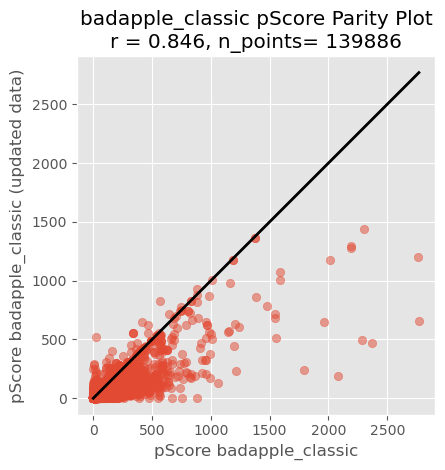

In [42]:
# visualize parity plot 
ylabel = "pScore badapple_classic (updated data)"
plot_title = f"badapple_classic pScore Parity Plot\nr = %.3f, n_points= %d" % (correlation, len(shared_df))
create_parity_plot(shared_df, ORIGINAL_PSCORE_COL_NAME, COMPARISON_PSCORE_COL_NAME, plot_title, "classic_updated_parity_plot.png")
plt.show()

# Close DB connections

In [43]:
# Close the cursors
original_db_cur.close()
comparison_db_cur.close()

# Close the connections
original_db_connection.close()
comparison_db_connection.close()